In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from copy import deepcopy as dc
import math
# import ray
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler

random.seed(42)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Loading the Apple.Inc Stock Data
import yfinance as yf
from datetime import date, timedelta, datetime

end_date = date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date
start_date = '1990-01-01' # Beginning date for our historical data retrieval

df = yf.download('AAPL', start=start_date, end=end_date)# Function used to fetch the data

data = df[["Close"]]
data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
1990-01-02,0.332589
1990-01-03,0.334821
1990-01-04,0.335938
1990-01-05,0.337054
1990-01-08,0.339286
...,...
2024-07-26,217.960007
2024-07-29,218.240005
2024-07-30,218.800003


In [3]:
def prepare_dataframe(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 50
shifted_df = prepare_dataframe(data, lookback)

shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-41),Close(t-42),Close(t-43),Close(t-44),Close(t-45),Close(t-46),Close(t-47),Close(t-48),Close(t-49),Close(t-50)
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-14,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,0.308036,0.301339,0.305804,...,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054,0.335938,0.334821,0.332589
1990-03-15,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,0.308036,0.301339,...,0.311384,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054,0.335938,0.334821
1990-03-16,0.359375,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,0.308036,...,0.296875,0.311384,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054,0.335938
1990-03-19,0.378348,0.359375,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,...,0.289063,0.296875,0.311384,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054
1990-03-20,0.369420,0.378348,0.359375,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,...,0.305804,0.289063,0.296875,0.311384,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,217.960007,217.490005,218.539993,225.009995,223.960007,224.309998,224.179993,228.880005,234.820007,234.399994,...,189.990005,189.979996,186.880005,190.899994,192.350006,191.039993,189.869995,189.839996,189.720001,187.429993
2024-07-29,218.240005,217.960007,217.490005,218.539993,225.009995,223.960007,224.309998,224.179993,228.880005,234.820007,...,190.289993,189.990005,189.979996,186.880005,190.899994,192.350006,191.039993,189.869995,189.839996,189.720001
2024-07-30,218.800003,218.240005,217.960007,217.490005,218.539993,225.009995,223.960007,224.309998,224.179993,228.880005,...,191.289993,190.289993,189.990005,189.979996,186.880005,190.899994,192.350006,191.039993,189.869995,189.839996


In [4]:
shifted_df_as_numpy = shifted_df.to_numpy()

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_numpy)

shifted_df_as_np

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

train_split = int(len(X) * 0.8)

X_train = X[:train_split]
X_test = X[train_split:]

y_train = y[:train_split]
y_test = y[train_split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6929, 50), (1733, 50), (6929,), (1733,))

In [5]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train shape: (6929, 50, 1)
X_test shape: (1733, 50, 1)


((6929, 50, 1), (1733, 50, 1), (6929, 1), (1733, 1))

In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6929, 50, 1]),
 torch.Size([1733, 50, 1]),
 torch.Size([6929, 1]),
 torch.Size([1733, 1]))

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [9]:
model = RNN(input_size=50, hidden_size=128, num_layers=2)
model.to(device)

model = torch.compile(model)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

max_lr = 1e-4
min_lr = max_lr * 0.1
warmup_steps = 200
max_steps = 500

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

torch.set_float32_matmul_precision('high')

In [14]:
def train_one_epoch():
    # model = torch.compile(model)
    model.train(True)
    print(f'Epoch: {epoch + 1}')

    running_loss = 0.0  # Initialize running_loss

    train_loader_tmp = dc(train_loader)

    for batch_index, batch in enumerate(train_loader_tmp):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Normalize input data if not already done
        x_batch = (x_batch - x_batch.mean(dim=0)) / x_batch.std(dim=0)

        x_batch = x_batch.view(x_batch.size(0), -1, 50) # Assuming you want to flatten the first two dimensions into a sequence of length 50

        # Forward pass through the model
        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.bfloat16):
          output = model(x_batch)

          # Clamp outputs to avoid extreme values
          output = torch.clamp(output, min=-1e9, max=1e9)

          # Calculate loss
          loss = loss_function(output, y_batch[:, 0])

        if torch.isnan(loss):
            print("NaN loss detected")
            continue

        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Learning rate scheduling
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(epoch * len(train_loader) + batch_index)

        # Check for NaN in gradients
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN found in gradients of {name}")

        optimizer.step()

    print(f'Training Loss: {running_loss / len(train_loader)}')

def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    test_loader_tmp = dc(test_loader)

    for batch_index, batch in enumerate(test_loader_tmp):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        x_batch = x_batch.view(x_batch.size(0), -1, 50) # Assuming you want to flatten the first two dimensions into a sequence of length 50

        with torch.inference_mode():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [15]:
num_epochs = 50
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

    # Check for NaN in model parameters after each epoch
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"NaN found in {name}")

Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss: 0.4750343107785772
Val Loss: 0.797
***************************************************

Epoch: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss: 0.009401780145440233
Val Loss: 1.083
***************************************************

Epoch: 3
Training Loss: 0.00750038281194694
Val Loss: 1.089
***************************************************

Epoch: 4
Training Loss: 0.00750964986104604
Val Loss: 1.094
***************************************************

Epoch: 5
Training Loss: 0.007488622516822843
Val Loss: 1.097
***************************************************

Epoch: 6
Training Loss: 0.007477435020489558
Val Loss: 1.098
***************************************************

Epoch: 7
Training Loss: 0.007501359982845215
Val Loss: 1.099
***************************************************

Epoch: 8
Training Loss: 0.007484735583045309
Val Loss: 1.098
***************************************************

Epoch: 9
Training Loss: 0.007479968451796108
Val Loss: 1.099
***************************************************

Epoch: 10
Training Loss: 0.007478822876746479
Val Loss: 1.098
*************************************

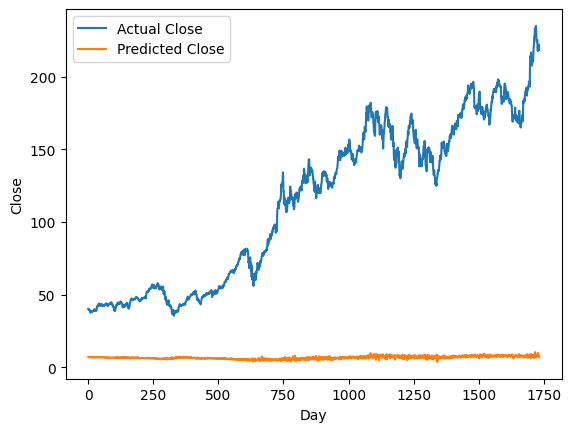

In [18]:
# Reshape X_test to have the expected last dimension of 50
test_predictions = model(X_test.to(device).view(X_test.size(0), -1, 50)).detach().cpu().numpy().flatten()

# Adjust the number of features in 'dummies' to match what the scaler expects (51)
dummies = np.zeros((X_test.shape[0], 51))  # Change from lookback+3 to 51
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

# Similarly, adjust the number of features here
dummies = np.zeros((X_test.shape[0], 51))  # Change from lookback+3 to 51
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()